# Implementasi Feed Forward Neural Network

In [14]:
import math
from enum import Enum

E = math.e

## Setup Activation Function


In [15]:
def linearFunction(val: float) -> float:
  return val

def reLUFunction(val: float) -> float :
  return max(0, val)

def sigmoidFunction(val: float) -> float:
  return 1 / (1 + E ** (-val))

def softMaxFunction(val: float) -> float:
  return E ** val

activationFunction = {
  'Linear': linearFunction,
  'ReLU': reLUFunction,
  'Sigmoid': sigmoidFunction,
  'SoftMax' : softMaxFunction
}

## Setup Class

### Class: Node

In [16]:
import string
from typing import List
class Node:
    def __init__(self, id : int, layerId : int, weight: List[float] = None, bias: int = None, activFunctionType : str = None) -> None:
        self.id = id
        self.layerId = layerId
        self.activFunctionType = activFunctionType
        self.weight = weight
        self.bias = bias

    def calculateOutput(self, inputArr: List[float]) -> float:
      sumWeight = 0
      if(len(self.weight) != len(inputArr)):
        raise Exception('Length of weight value array and input array not compatible')
      for i in range(len(self.weight)):
        sumWeight += self.weight[i] * inputArr[i]
      sumWeight += self.bias

      return round(activationFunction[self.activFunctionType](sumWeight), 2)
    
    def describe(self) -> None:
      print(f"Node with id {self.id}:")
      print(f"\tLayer id -> {self.layerId}")
      print(f"\tWeight -> {self.weight}")
      print(f"\tBias -> {self.bias}")
      print(f"\tActivation function -> {self.activFunctionType}")

'''
  Test Case For Node
'''
# instanceNode = Node(1, 1, [1, 0.8, 0.2], 0.3, "Sigmoid")
# instanceNode.describe()
# instanceNode.calculateOutput([1, 2, 3])


'\n  Test Case For Node\n'

### Class: Layer

In [17]:
class LayerType(Enum):
  Input = 1
  Hidden = 2
  Output = 3

class Layer():
  def __init__(self, id: int, nodeAmount: int, layerType : LayerType, nodes : List[Node]) -> None:
    self.id = id
    self.nodeAmount = nodeAmount
    self.layerType = layerType
    self.nodes = nodes # node in here only store non-bias node
    assert self.nodeAmount == len(nodes)
  
  def appendNode(self, newNode : Node) -> None:
    self.nodes.append(newNode)
  
  def describe(self) -> None:
    print(f"Layer with id {self.id}:")
    print(f"\tAmount of node -> {self.nodeAmount}")
    print(f"\tLayer type -> {self.layerType}")
    for node in self.nodes:
      node.describe()

  def __eq__(self, otherLayer) -> bool:
    if isinstance(otherLayer, Layer):
        return self.id == otherLayer.id
    return False
  

### Class: ANNModel

In [18]:
class ANNModel():
  def __init__(self, layers: List[Layer] = []) -> None:
    self.layers = layers
  
  def appendLayer(self, layer: Layer) -> None:
    self.layers.append(layer)

  def countLayer(self) -> int: 
    return len(self.layers)
  
  def getLayerById(self, layerId: int) -> Layer:
    for layer in self.layers:
      if(layer.id == layerId):
        return layer
    raise Exception("No layer with the prompted id")
  
  def getPreviousLayer(self, targetLayer: Layer) -> Layer:
    if(targetLayer.layerType == LayerType.Input):
      raise Exception("Input layer does not have previous layer")
    prevLayer: Layer = None
    for layer in self.layers:
      if layer == targetLayer:
        return prevLayer
      else: 
        prevLayer = layer
    
    raise Exception("Layer you try to input as parameter is invalid")
  
  def predict(self, inputValue: List[float]) -> List[float]:
    amountInputNode = 0
    layerCalculation: List[float] = []
    for layer in self.layers:
      layerCalculation = layerCalculation[-amountInputNode:]
      if layer.layerType == LayerType.Input:
        pass
      else:
        if (layer.nodes[0].activFunctionType == "SoftMax"):
          # menghitung sum untuk softmax
          sum = 0
        for node in layer.nodes:
          if(layer.id == 1):
            tempVal = node.calculateOutput(inputValue)
          else:
            tempVal = node.calculateOutput(layerCalculation)
          sum += tempVal
          layerCalculation.append(tempVal)
        if (layer.nodes[0].activFunctionType == "SoftMax"):
          # membagi setiap node dengan sum
          for i in range(len(layerCalculation)):
            layerCalculation[i] /= sum
        
      amountInputNode = layer.nodeAmount
    return layerCalculation[-amountInputNode:] # The length is based on the amount of node of the output layer
  
  def predictMultiple(self, inputValues: List[List[float]]) -> List[float]:
    result: List[float] = []
    for val in inputValues:
      result.append(self.predict(val))
    return result

  def describe(self) -> None:
    for layer in self.layers:
      layer.describe()
      print("\n")

## File Loader

In [19]:
annModelInstance = ANNModel([])

modelFileName = input("Masukan nama file model: ")

with open('../model/' + modelFileName, 'r') as f:
  nodeInfo = []
  for idLine, line in enumerate(f):
    if(idLine == 0):
      firstLine = line.split()
      firstLine = [int(x) for x in firstLine]
      amountLayer, amountNode = firstLine[0], firstLine[1:]
      if(len(amountNode) != amountLayer):
        raise Exception('File input wrong format: The amount of layer is invalid')
    else:
      nextLine = line.split()
      weight, activType = nextLine[:-1], nextLine[-1:]
      weight = [float(x) for x in weight]
      result = weight + activType
      nodeInfo.append(result)

  # * Set up ANN model
  currentNodeId = 0
  currentLayerId = 0

  for i in range(amountLayer):
    if(i == 0): # ** Handle input layer
      inputNodes = []
      for j in range(amountNode[0]):
        newNode = Node(currentNodeId, currentLayerId)
        inputNodes.append(newNode)
        currentNodeId += 1
      inputLayer = Layer(currentLayerId, amountNode[0], LayerType.Input, inputNodes)
      annModelInstance.appendLayer(inputLayer)
    else: # ** Handle hidden and output layer
      layerNodes = []
      for k in range(amountNode[i]):
        currentNodeInfo = nodeInfo[0]
        newNode = Node(currentNodeId, currentLayerId, currentNodeInfo[:-2], currentNodeInfo[-2], currentNodeInfo[-1])
        layerNodes.append(newNode); 
        nodeInfo.pop(0)
        currentNodeId += 1
      layer = Layer(currentLayerId, amountNode[i], LayerType.Output if len(nodeInfo) == 0 else LayerType.Hidden, layerNodes)
      annModelInstance.appendLayer(layer)
    currentLayerId += 1

'''
  Test Case For ANNModel
'''
# layer0 = annModelInstance.getLayerById(0)
# layer1 = annModelInstance.getLayerById(1)
# layer2 = annModelInstance.getLayerById(2)

# prevOfLayer1 = annModelInstance.getPreviousLayer(layer1)
# if(prevOfLayer1 == layer0):
#   print("Success")
# else:
#   print("Failed")

'\n  Test Case For ANNModel\n'

## Visualize ANN

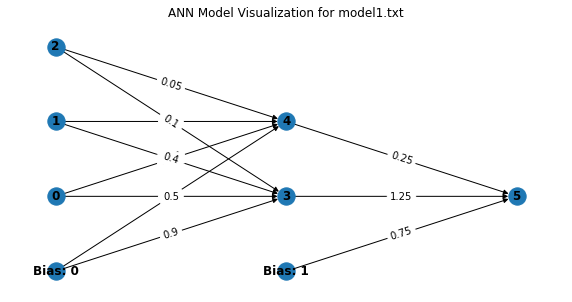

In [20]:
# pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
# from networkx.drawing.nx_agraph import graphviz_layout

def drawANNVisualization(annModelInstance: ANNModel):
  G = nx.DiGraph()

  for i, layer in enumerate(annModelInstance.layers):
    if(layer.layerType != LayerType.Input):
      prevLayer = annModelInstance.getPreviousLayer(layer)
    if(layer.layerType != LayerType.Output):
      G.add_node(f'Bias: {i}', pos=(i, -1))

    for j, node in enumerate(layer.nodes):
      counter = 0
      G.add_node(node.id, pos=(i, j))
      if(layer.layerType == LayerType.Input):
        pass
      else:
        G.add_edge(f'Bias: {i - 1}', node.id, weight=node.bias)
        for prevNode in prevLayer.nodes:
          currWeight = node.weight[counter]
          G.add_edge(prevNode.id, node.id, weight=currWeight)
          counter +=1
        

  pos=nx.get_node_attributes(G,'pos')
  edgeLabel = nx.get_edge_attributes(G, 'weight')
  plt.figure(figsize=(10,5))
  ax = plt.gca()
  ax.set_title(f'ANN Model Visualization for {modelFileName}')
  nx.draw(G,with_labels=True,pos=pos, font_weight='bold', ax=ax)
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edgeLabel)

# * Test
drawANNVisualization(annModelInstance)

In [21]:
annModelInstance.describe()

Layer with id 0:
	Amount of node -> 3
	Layer type -> LayerType.Input
Node with id 0:
	Layer id -> 0
	Weight -> None
	Bias -> None
	Activation function -> None
Node with id 1:
	Layer id -> 0
	Weight -> None
	Bias -> None
	Activation function -> None
Node with id 2:
	Layer id -> 0
	Weight -> None
	Bias -> None
	Activation function -> None


Layer with id 1:
	Amount of node -> 2
	Layer type -> LayerType.Hidden
Node with id 3:
	Layer id -> 1
	Weight -> [0.5, 0.4, 0.1]
	Bias -> 0.9
	Activation function -> SoftMax
Node with id 4:
	Layer id -> 1
	Weight -> [0.25, 0.2, 0.05]
	Bias -> 0.8
	Activation function -> ReLU


Layer with id 2:
	Amount of node -> 1
	Layer type -> LayerType.Output
Node with id 5:
	Layer id -> 2
	Weight -> [1.25, 0.25]
	Bias -> 0.75
	Activation function -> Sigmoid




## Hasil Output Layer

### Kasus satu instance

In [25]:
# * Untuk kasus model2.txt
# annModelInstance.predict([2, 1, 1, 4]) # Kalau input layer ada 4 node (5 node kalau bias diitung)

# * Untuk kasus model1.txt
# annModelInstance.predict([2, 1, 1]) # Kalau input layer ada 3 node (4 node kalau bias diitung)

#### Kasus model1.txt

Untuk kasus dimana input layer memiliki tiga buah node (empat node jika bias termasuk), output layer yang memiliki satu node dengan fungsi aktivasi sigmoid menghasilkan hasil `0.87`

#### Kasus model2.txt

Untuk kasus dimana input layer memiliki empat buah node (lima node jika bias termasuk), output layer yang memiliki satu node dengan fungsi aktivasi sigmoid menghasilkan hasil `0.9`

In [26]:
# * Untuk kasus model2.txt
# annModelInstance.predictMultiple([[2, 1, 1, 4], [14, 2, 1, 3], [1, 0.2, 0.5, 2]]) # Kalau input layer ada 4 node (5 node kalau bias diitung)

# * Untuk kasus model1.txt
# annModelInstance.predictMultiple([[2, 1, 1], [14, 2, 1], [1, 0.2, 0.5]]) # Kalau input layer ada 3 node (4 node kalau bias diitung)

[[0.87], [0.88], [0.86]]

#### Kasus model1.txt

Untuk kasus dimana input layer memiliki tiga buah node (empat node jika bias termasuk), output layer yang memiliki satu node dengan fungsi aktivasi sigmoid menghasilkan hasil berturut turut `0.87`, `0.88`, dan `0.86` untuk instance `[2, 1, 1]`, `[14, 2, 1]`, dan `[1, 0.2, 0.5]`

#### Kasus model2.txt

Untuk kasus dimana input layer memiliki empat buah node (lima node jika bias termasuk), output layer yang memiliki satu node dengan fungsi aktivasi sigmoid menghasilkan hasil berturut turut `0.9`, `0.9`, dan `0.89` untuk instance `[2, 1, 1, 4]`, `[14, 2, 1, 3]`, dan `[1, 0.2, 0.5, 2]`